In [1]:
import stim
import numpy as np
from numpy.linalg import matrix_power, matrix_rank
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sinter
from mec import make_circle
from typing import List
import pymatching
import galois
from collections import Counter

In [2]:

# code = [15,3,11,0,1,0,13,2]
# code = [15,3,11,2,0,0,11,13]
# code = [15,3,12,2,1,1,3,7]
code = [3,15,11,2,0,0,11,13,3,15,2,5]


In [3]:
def cyclic_shift_matrix(l):
    arr = np.eye(l, dtype=int)
    return np.roll(arr, axis=1, shift=1)

ell = code[1]
m = code[0]

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

A1 = matrix_power(x, code[2])
A2 = matrix_power(y, code[3])
A3 = matrix_power(y, code[4])
A = ( A1 + A2 + A3 ) % 2

B1 = matrix_power(y, code[5])
B2 = matrix_power(x, code[6])
B3 = matrix_power(x, code[7])
B = ( B1 + B2 + B3 ) % 2

Hx = np.hstack([A, B]).astype(int)
Hz = np.hstack([B.T, A.T]).astype(int)

In [4]:
def par2gen(H):
    GF = galois.GF(2)
    gfH = GF(H)
    gfH_rank = np.linalg.matrix_rank(gfH)

    rref_H = gfH.row_reduce()

    swaps = []
    col_H = rref_H.copy()
    for i in range(gfH_rank):
        inds = np.where(col_H[i])[0]
        pivot = inds[0]
        col_H[:,[i,pivot]] = col_H[:,[pivot,i]]
        swaps.append((i,pivot))

    col_H = col_H[:gfH_rank]
    col_G = GF(np.hstack([col_H[:,gfH_rank:].T, np.eye(H.shape[1]-gfH_rank, dtype=int)]))

    G = col_G.copy()
    for swap in swaps[::-1]:
        G[:,[swap[1],swap[0]]] = G[:,[swap[0],swap[1]]]

    if (np.any(G @ rref_H[:gfH_rank].T) or np.any(col_G @ col_H.T)):
        print("FAILED")
        return
    return (np.array(G, dtype=int), np.array(col_G, dtype=int))

def commute(x, z, n):
    # 0 if commute, 1 if anticommute
    x1 = x[:n]
    x2 = x[n:]
    z1 = z[:n]
    z2 = z[n:]
    return (x1 @ z2 % 2) ^ (x2 @ z1 % 2)
    

def SGSOP(Gx, Gz, n):
    # symplectic gram-schmidt orthogonalization procedure
    sym_Gx = np.hstack([Gx, np.zeros(Gx.shape, dtype=int)])
    sym_Gz = np.hstack([np.zeros(Gz.shape, dtype=int), Gz])
    sym_G = np.vstack([sym_Gx, sym_Gz])
    logicals = []
    generators = []

    while(sym_G.shape[0]):
        g1 = sym_G[0]

        commutes = True
        for i in range(1, sym_G.shape[0]-1):
            g2 = sym_G[i]
            if (commute(g1,g2,n)):
                logicals.append((g1, g2))
                sym_G = np.delete(sym_G, [0, i], axis=0)

                for j in range(sym_G.shape[0]):
                    gj = sym_G[j]
                    sym_G[j] = gj ^ (commute(gj,g2,n) * g1) ^ (commute(gj,g1,n) * g2)
                commutes = False
                break
        
        if commutes:
            generators.append(g1)
            sym_G = np.delete(sym_G, 0, axis=0)
    
    return (logicals, generators)

In [5]:
def get_logicals(gen_type=False):
    n = Hx.shape[1]
    Gx, col_Gx = par2gen(Hx)
    Gz, col_Gz = par2gen(Hz)
    logicals, generators = SGSOP(Gx, Gz, n)

    logX = np.array([l[1][n:] for l in logicals])
    logZ = np.array([l[0][:n] for l in logicals])

    if gen_type: return logX
    else: return logZ

In [6]:
def embed_code(code, init):
    emb_m, emb_ell, A_ind, B_ind = code

    lattice = np.empty((2*emb_m, 2*emb_ell), dtype=object)
    lattice[0][0] = f"x{init}"

    # As = [[A1, A2.T], [A2, A3.T], [A1, A3.T]]
    # Bs = [[B1, B2.T], [B2, B3.T], [B1, B3.T]]
    As = [[A1, A2.T], [A2, A1.T], [A2, A3.T], [A3, A2.T], [A1, A3.T], [A3, A1.T]]
    Bs = [[B1, B2.T], [B2, B1.T], [B2, B3.T], [B3, B2.T], [B1, B3.T], [B3, B1.T]]

    def get_nbr(i, j):
        if (i % 2 == 0):
            if (j % 2 == 0):
                return "x"
            else:
                return "r"
        else:
            if (j % 2 == 0):
                return "l"
            else:
                return "z"

    for i in range(2*emb_m - 1):
        for j in range(2*emb_ell):
            curr_ind = int(lattice[i][j][1:])

            if (i % 2 == 0):
                tmp_A = As[A_ind][1]
            else:
                tmp_A = As[A_ind][0]
            if (j % 2 == 0):
                tmp_B = Bs[B_ind][1]
            else:
                tmp_B = Bs[B_ind][0]

            lattice[(i+1)%(2*emb_m)][j] = f"{get_nbr((i+1)%(2*emb_m), j)}{np.where(tmp_A @ np.eye(m*ell)[curr_ind])[0][0]}"
            lattice[i][(j+1)%(2*emb_ell)] = f"{get_nbr(i, (j+1)%(2*emb_ell))}{np.where(tmp_B @ np.eye(m*ell)[curr_ind])[0][0]}"

    for i in range(2*emb_m):
        for j in range(2*emb_ell):
            if (lattice[i][j][0] == "z"):
                lattice[i][j] = f"z{int(lattice[i][j][1:]) + m*ell}"
            elif (lattice[i][j][0] == "r"):
                lattice[i][j] = f"r{int(lattice[i][j][1:]) + m*ell}"

    return lattice

# np.set_printoptions(linewidth=90)
# lattice = embed_code((3,15,2,5), 0)
lattice = embed_code((code[8],code[9],code[10],code[11]), 0)

In [7]:
all_qbts = {}

qbts = np.array([None for i in range(2*m*ell)])
for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
            all_qbts[(i,j)] = int(lattice[i][j][1:])
            qbts[int(lattice[i][j][1:])] = (i, j)
x_checks = np.array([None for i in range(m*ell)])
z_checks = np.array([None for i in range(m*ell)])

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            all_qbts[(i,j)] = int(lattice[i][j][1:]) + 2*m*ell
            x_checks[int(lattice[i][j][1:])] = (i, j)
        elif lattice[i][j][0] == "z":
            all_qbts[(i,j)] = int(lattice[i][j][1:]) + 2*m*ell
            z_checks[int(lattice[i][j][1:])-(m*ell)] = (i, j)

x_rs = []
z_rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    x_rs.append(make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    z_rs.append(make_circle(gen_qbts)[2])

lr_x_checks = []
sr_x_checks = []
lr_z_checks = []
sr_z_checks = []

for i, x_check in enumerate(x_checks):
    gen_qbts = qbts[np.where(Hx[i])[0]]

    nonlocal_qbts = []
    if (x_rs[i] > (min(x_rs)+np.std(x_rs))):
        lr_x_checks.append(i)
    else:
        sr_x_checks.append(i)

for i, z_check in enumerate(z_checks):
    gen_qbts = qbts[np.where(Hz[i])[0]]

    nonlocal_qbts = []
    if (z_rs[i] > min(z_rs)+np.std(z_rs)):
        lr_z_checks.append(i)
    else:
        sr_z_checks.append(i)

In [8]:
def get_ancilla_allocations():
    gens = []
    for i, x in enumerate(lr_x_checks):
        x_check = x_checks[x]
        gen_qbts = qbts[np.where(Hx[x])[0]]

        nonlocal_qbts = []
        for qbt in gen_qbts:
            if (abs(qbt[0] - x_check[0]) + abs(qbt[1] - x_check[1])) > 2*m:
                nonlocal_qbts.append(qbt)
        gens.append([nonlocal_qbts, x_checks[x]])
        
    for i, z in enumerate(lr_z_checks):
        z_check = z_checks[z]
        gen_qbts = qbts[np.where(Hz[z])[0]]

        nonlocal_qbts = []
        for qbt in gen_qbts:
            if (abs(qbt[0] - z_check[0]) + abs(qbt[1] - z_check[1])) > 2*m:
                nonlocal_qbts.append(qbt)
        gens.append([nonlocal_qbts, z_checks[z]])

    anc_alloc = {}
    for gen in gens:
        anc_alloc[gen[1]] = len(gen[0])
    c = Counter(list(itertools.chain(*[gen[0] for gen in gens])))
    for qbt, anc in c.items():
        anc_alloc[qbt] = anc
    
    return anc_alloc

In [9]:
def lr_bell_pair(paths):
    size = len(path)
    c = stim.Circuit()

    for path in paths:
        c.append("H", path[:-1][::2])

    c.append("CNOT", path[:size-(size%2)])
    c.append("TICK")
    c.append("CNOT", path[1:size-1+(size%2)])

    c.append("H", path[:-1][1::2])
    c.append("MR", path[1:-1])

    for i in range(2 - (size%2), size-1, 2):
        c.append("CZ", [stim.target_rec(-i), path[0]])
    for i in range(1 + (size%2), size-1, 2):
        c.append("CX", [stim.target_rec(-i), path[-1]])
    
    return c

def lr_CNOT_bell(control, target, bell_pair):
    c = stim.Circuit()

    c.append("TICK")
    c.append("CNOT", [control, bell_pair[0], bell_pair[1], target])
    c.append("MR", bell_pair[0])
    c.append("MRX", bell_pair[1])
    c.append("CX", [stim.target_rec(-2), target])
    c.append("CZ", [stim.target_rec(-1), control])

    return c

def lr_CNOT_no_bell(paths):
    # path[0] is control, path[-1] is target. Reverse path to get reverse CNOT
    c = stim.Circuit()
    
    for path in paths:
        size = len(path)
        c.append("H", path[:-1][2::2])
        # c.append("DEPOLARIZE1", path[:-1][2::2], 0.001)
    c.append("TICK")

    for path in paths:
        size = len(path)
        c.append("CNOT", path[:size-(size%2)])
        # c.append("DEPOLARIZE2", path[:size-(size%2)], 0.001)
    c.append("TICK")

    for path in paths:
        size = len(path)
        c.append("CNOT", path[1:size-1+(size%2)])
        # c.append("DEPOLARIZE2", path[1:size-1+(size%2)], 0.001)
    c.append("TICK")
    
    for path in paths:
        c.append("H", path[:-1][1::2])
        # c.append("DEPOLARIZE1", path[:-1][2::2], 0.001)
    c.append("TICK")

    for path in paths:
        c.append("MR", path[1:-1])
    c.append("TICK")

    # for j, path in enumerate(paths):
    #     size = len(path)
    #     for i in range(2 - (size%2), size-1, 2):
    #         c.append("CZ", [stim.target_rec(-(size-2)*(num_paths-1-j)-i), path[0]])
    #         # c.append("CZ", [stim.target_rec(-i), path[0]])
    #     for i in range(1 + (size%2), size-1, 2):
    #         c.append("CX", [stim.target_rec(-(size-2)*(num_paths-1-j)-i), path[-1]])
    #         # c.append("CX", [stim.target_rec(-i), path[-1]])
    # c.append("TICK")

    for j, path in enumerate(paths):
        tot_len = sum([len(p[1:-1]) for p in paths[j:]])
        size = len(path)
        for i in range(1 + (size%2), size-1, 2):
            c.append("CZ", [stim.target_rec(-tot_len+i-1), path[0]])
            # c.append("CZ", [stim.target_rec(-i), path[0]])
        for i in range(2 - (size%2), size-1, 2):
            c.append("CX", [stim.target_rec(-tot_len+i-1), path[-1]])
            # c.append("CX", [stim.target_rec(-i), path[-1]])
    c.append("TICK")

    return c

In [10]:
c = stim.Circuit()

for key, value in all_qbts.items():
    c.append("QUBIT_COORDS", value, (key[0],key[1],0))
    c.append("QUBIT_COORDS", value+(4*m*ell), (key[0],key[1],1))

# anc_alloc = get_ancilla_allocations()
# for key, value in anc_alloc.items():
#     for i in range(value):
#         c.append("QUBIT_COORDS", all_qbts[key]+(i+2)*(4*m*ell), (key[0],key[1],i+2))

c.append("R", [qbt for qbt in all_qbts.values()])
c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])

In [12]:
def sr_x_up_right(gen_index):
    x_checks_i = [x for x in sr_x_checks if ((x_checks[x][1]//2)%3==gen_index)]
    x_paths = [[(x_checks[x][0], x_checks[x][1])]+[(x_checks[x][0]+1, x_checks[x][1]-i) for i in range(5)] for x in x_checks_i]
    return x_paths

def sr_x_up(gen_index):
    x_checks_i = [x for x in sr_x_checks if ((x_checks[x][1]//2)%3==gen_index)]
    x_paths = [[(x_checks[x][0], x_checks[x][1]-i) for i in range(4)] for x in x_checks_i]
    return x_paths

def sr_x_left():
    x_checks_i = [x for x in sr_x_checks if (x_checks[x][0]==0)]
    x_paths = [[(x_checks[x][0]+i, x_checks[x][1]) for i in range(6)] for x in x_checks_i]
    return x_paths

def sr_z_down_left(gen_index):
    z_checks_i = [z for z in sr_z_checks if ((z_checks[z][1]//2)%3==gen_index)]
    z_paths = [[(z_checks[z][0]-1, z_checks[z][1]+i) for i in range(5)][::-1]+[(z_checks[z][0], z_checks[z][1])] for z in z_checks_i]
    return z_paths

def sr_z_down(gen_index):
    z_checks_i = [z for z in sr_z_checks if ((z_checks[z][1]//2)%3==gen_index)]
    z_paths = [[(z_checks[z][0], z_checks[z][1]+i) for i in range(4)][::-1] for z in z_checks_i]
    return z_paths

def sr_z_right():
    z_checks_i = [z for z in sr_z_checks if (z_checks[z][0]==5)]
    z_paths = [[(z_checks[z][0]-i, z_checks[z][1]) for i in range(6)][::-1] for z in z_checks_i]
    return z_paths

# -------------------------------------------------------------------

def lr_x_down(gen_index): # 0 or 1
    x_checks_i = [x for x in lr_x_checks if ((x_checks[x][1]//2)%3)==gen_index]
    x_paths = [[(x_checks[x][0], x_checks[x][1]+i) for i in range(28)] for x in x_checks_i]
    return x_paths

def lr_x_down_right(gen_index): # 0 or 1
    x_checks_i = [x for x in lr_x_checks if ((x_checks[x][1]//2)%3)==gen_index]
    x_paths = [[(x_checks[x][0], x_checks[x][1])]+[(x_checks[x][0]+1, x_checks[x][1]+i) for i in range(27)] for x in x_checks_i]
    return x_paths

def lr_x_up_down(gen_index=0): # only 0
    x_checks_i = [x for x in lr_x_checks if ((x_checks[x][1]//2)%3)==gen_index]
    x_paths = [[(x_checks[x][0], x_checks[x][1]+i) for i in range(30)] for x in x_checks_i]
    return x_paths

def lr_x_left():
    x_checks_i = [x for x in lr_x_checks if (x_checks[x][0]==0)]
    x_paths = [[(x_checks[x][0]+i, x_checks[x][1]) for i in range(6)] for x in x_checks_i]
    return x_paths

def lr_z_down_up(gen_index=2): # only 2
    z_checks_i = [z for z in lr_z_checks if ((z_checks[z][1]//2)%3)==gen_index]
    z_paths = [[(z_checks[z][0], z_checks[z][1]-i) for i in range(30)][::-1] for z in z_checks_i]
    return z_paths

def lr_z_up(gen_index): # 1 or 2
    z_checks_i = [z for z in lr_z_checks if ((z_checks[z][1]//2)%3)==gen_index]
    z_paths = [[(z_checks[z][0], z_checks[z][1]-i) for i in range(28)][::-1] for z in z_checks_i]
    return z_paths

def lr_z_up_left(gen_index): # 1 or 2
    z_checks_i = [z for z in lr_z_checks if ((z_checks[z][1]//2)%3)==gen_index]
    z_paths = [[(z_checks[z][0]-1, z_checks[z][1]-i) for i in range(27)][::-1]+[(z_checks[z][0], z_checks[z][1])] for z in z_checks_i]
    return z_paths

def lr_z_right():
    z_checks_i = [z for z in lr_z_checks if (z_checks[z][0]==5)]
    z_paths = [[(z_checks[z][0]-i, z_checks[z][1]) for i in range(6)][::-1] for z in z_checks_i]
    return z_paths

# --------------------------------------------------------------------

def xz_down(checks):
    c = stim.Circuit()
    for x_check in checks[0]:
        pos = x_checks[x_check]
        if (pos[1] < 2*ell-1): 
            c.append("CNOT", [all_qbts[x_checks[x_check]], all_qbts[(pos[0], pos[1]+1)]])
            c.append("DEPOLARIZE2", [all_qbts[x_checks[x_check]], all_qbts[(pos[0], pos[1]+1)]], 0.001)
    for z_check in checks[1]:
        pos = z_checks[z_check]
        if (pos[1] < 2*ell-1): 
            c.append("CNOT", [all_qbts[(pos[0], pos[1]+1)], all_qbts[z_checks[z_check]]])
            c.append("DEPOLARIZE2", [all_qbts[(pos[0], pos[1]+1)], all_qbts[z_checks[z_check]]], 0.001)
    c.append("TICK")
    return c

def xz_right(checks):
    c = stim.Circuit()
    for x_check in checks[0]:
        pos = x_checks[x_check]
        if (pos[0] > 0): 
            c.append("CNOT", [all_qbts[x_checks[x_check]], all_qbts[(pos[0]-1, pos[1])]])
            c.append("DEPOLARIZE2", [all_qbts[x_checks[x_check]], all_qbts[(pos[0]-1, pos[1])]], 0.001)
    for z_check in checks[1]:
        pos = z_checks[z_check]
        if (pos[0] > 0): 
            c.append("CNOT", [all_qbts[(pos[0]-1, pos[1])], all_qbts[z_checks[z_check]]])
            c.append("DEPOLARIZE2", [all_qbts[(pos[0]-1, pos[1])], all_qbts[z_checks[z_check]]], 0.001)
    c.append("TICK")
    return c

def xz_left(checks):
    c = stim.Circuit()
    for x_check in checks[0]:
        pos = x_checks[x_check]
        if (pos[0] < 2*m-1): 
            c.append("CNOT", [all_qbts[x_checks[x_check]], all_qbts[(pos[0]+1, pos[1])]])
            c.append("DEPOLARIZE2", [all_qbts[x_checks[x_check]], all_qbts[(pos[0]+1, pos[1])]], 0.001)
    for z_check in checks[1]:
        pos = z_checks[z_check]
        if (pos[0] < 2*m-1): 
            c.append("CNOT", [all_qbts[(pos[0]+1, pos[1])], all_qbts[z_checks[z_check]]])
            c.append("DEPOLARIZE2", [all_qbts[(pos[0]+1, pos[1])], all_qbts[z_checks[z_check]]], 0.001)
    c.append("TICK")
    return c

def xz_up(checks):
    c = stim.Circuit()
    for x_check in checks[0]:
        pos = x_checks[x_check]
        if (pos[1] > 0): 
            c.append("CNOT", [all_qbts[x_checks[x_check]], all_qbts[(pos[0], pos[1]-1)]])
            c.append("DEPOLARIZE2", [all_qbts[x_checks[x_check]], all_qbts[(pos[0], pos[1]-1)]], 0.001)
    for z_check in checks[1]:
        pos = z_checks[z_check]
        if (pos[1] > 0): 
            c.append("CNOT", [all_qbts[(pos[0], pos[1]-1)], all_qbts[z_checks[z_check]]])
            c.append("DEPOLARIZE2", [all_qbts[(pos[0], pos[1]-1)], all_qbts[z_checks[z_check]]], 0.001)
    c.append("TICK")
    return c

# ---------------------------------------------------------------------


def direct_CNOT(paths):
    c = stim.Circuit()
    for path in paths:
        c.append("CNOT", [all_qbts[path[0]], all_qbts[path[-1]]])
        c.append("DEPOLARIZE2", [all_qbts[path[0]], all_qbts[path[-1]]], 0.001)
    c.append("TICK")
    return c


def sr_mr_checks(use_direct_CNOTS=False):
    # # # 10,3,15,11,2,0,0,11,13,3,15,2,5,0.005,0.1333333333333333,9501,9331,0.9821071466161456,8,4,0.5530895454860159,2.5495097567963927
    # # # SPECIFIC TO THIS CODE

    c = stim.Circuit()
    c.append("TICK")
    c.append("H", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks])
    c.append("DEPOLARIZE1", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks], 0.001)
    c.append("TICK")

    # down left for z0 checks
    # down for z1 checks
    # direct_CNOTS = []
    # path_qbts = []
    # for path in sr_z_down_left(0)+sr_z_down(1):
    #     # path_qbts.append([all_qbts[qbt] for i, qbt in enumerate(path)])
    #     path_qbts.append([all_qbts[qbt] + 4*m*ell if 0 < i < len(path)-1 else all_qbts[qbt] for i, qbt in enumerate(path)])
    #     direct_CNOTS.extend([path_qbts[-1][0], path_qbts[-1][-1]])

    # if use_direct_CNOTS:
    #     c.append("CNOT", direct_CNOTS)
    #     c.append("DEPOLARIZE2", direct_CNOTS)
    #     c.append("TICK")
    # else:
    #     c += lr_CNOT_no_bell(path_qbts)

    # down left for z1 checks
    # down for z2 checks
    direct_CNOTS = []
    path_qbts = []
    for path in sr_z_down_left(1)+sr_z_down(2):
        # path_qbts.append([all_qbts[qbt] for i, qbt in enumerate(path)])
        path_qbts.append([all_qbts[qbt] + 4*m*ell if 0 < i < len(path)-1 else all_qbts[qbt] for i, qbt in enumerate(path)])
        direct_CNOTS.extend([path_qbts[-1][0], path_qbts[-1][-1]])

    if use_direct_CNOTS:
        c.append("CNOT", direct_CNOTS)
        c.append("DEPOLARIZE2", direct_CNOTS)
        c.append("TICK")
    else:
        c += lr_CNOT_no_bell(path_qbts)


    # down left for z2 checks
    # down for z0 checks
    direct_CNOTS = []
    path_qbts = []
    for path in sr_z_down_left(2)+sr_z_down(0):
        # path_qbts.append([all_qbts[qbt] for i, qbt in enumerate(path)])
        path_qbts.append([all_qbts[qbt] + 4*m*ell if 0 < i < len(path)-1 else all_qbts[qbt] for i, qbt in enumerate(path)])
        direct_CNOTS.extend([path_qbts[-1][0], path_qbts[-1][-1]])

    if use_direct_CNOTS:
        c.append("CNOT", direct_CNOTS)
        c.append("DEPOLARIZE2", direct_CNOTS)
        c.append("TICK")
    else:
        c += lr_CNOT_no_bell(path_qbts)

    
    # down
    for x_check in sr_x_checks:
        pos = x_checks[x_check]
        if (pos[1] < 2*ell-1): 
            c.append("CNOT", [all_qbts[x_checks[x_check]], all_qbts[(pos[0], pos[1]+1)]])
            c.append("DEPOLARIZE2", [all_qbts[x_checks[x_check]], all_qbts[(pos[0], pos[1]+1)]], 0.001)
    for z_check in sr_z_checks:
        pos = z_checks[z_check]
        if (pos[1] < 2*ell-1): 
            c.append("CNOT", [all_qbts[(pos[0], pos[1]+1)], all_qbts[z_checks[z_check]]])
            c.append("DEPOLARIZE2", [all_qbts[(pos[0], pos[1]+1)], all_qbts[z_checks[z_check]]], 0.001)
    c.append("TICK")

    # right
    for x_check in sr_x_checks:
        pos = x_checks[x_check]
        if (pos[0] > 0): 
            c.append("CNOT", [all_qbts[x_checks[x_check]], all_qbts[(pos[0]-1, pos[1])]])
            c.append("DEPOLARIZE2", [all_qbts[x_checks[x_check]], all_qbts[(pos[0]-1, pos[1])]], 0.001)
    for z_check in sr_z_checks:
        pos = z_checks[z_check]
        if (pos[0] > 0): 
            c.append("CNOT", [all_qbts[(pos[0]-1, pos[1])], all_qbts[z_checks[z_check]]])
            c.append("DEPOLARIZE2", [all_qbts[(pos[0]-1, pos[1])], all_qbts[z_checks[z_check]]], 0.001)
    c.append("TICK")


    x_paths = sr_x_left()
    z_paths = sr_z_right()

    # NEED TO SWAP UP ANCILLAS. NOT BEGINNING OR END OF PATH
    path_qbts = []
    direct_CNOTS = []
    for path in x_paths+z_paths:
        path_qbts.append([all_qbts[qbt] + 4*m*ell if 0 < i < len(path)-1 else all_qbts[qbt] for i, qbt in enumerate(path)])
        direct_CNOTS.extend([path_qbts[-1][0], path_qbts[-1][-1]])

    if use_direct_CNOTS:
        c.append("CNOT", direct_CNOTS)
        c.append("DEPOLARIZE2", direct_CNOTS)
        c.append("TICK")
    else:
        c += lr_CNOT_no_bell(path_qbts)

    # left
    for x_check in sr_x_checks:
        pos = x_checks[x_check]
        if (pos[0] < 2*m-1): 
            c.append("CNOT", [all_qbts[x_checks[x_check]], all_qbts[(pos[0]+1, pos[1])]])
            c.append("DEPOLARIZE2", [all_qbts[x_checks[x_check]], all_qbts[(pos[0]+1, pos[1])]], 0.001)
    for z_check in sr_z_checks:
        pos = z_checks[z_check]
        if (pos[0] < 2*m-1): 
            c.append("CNOT", [all_qbts[(pos[0]+1, pos[1])], all_qbts[z_checks[z_check]]])
            c.append("DEPOLARIZE2", [all_qbts[(pos[0]+1, pos[1])], all_qbts[z_checks[z_check]]], 0.001)
    c.append("TICK")

    # up
    for x_check in sr_x_checks:
        pos = x_checks[x_check]
        if (pos[1] > 0): 
            c.append("CNOT", [all_qbts[x_checks[x_check]], all_qbts[(pos[0], pos[1]-1)]])
            c.append("DEPOLARIZE2", [all_qbts[x_checks[x_check]], all_qbts[(pos[0], pos[1]-1)]], 0.001)
    for z_check in sr_z_checks:
        pos = z_checks[z_check]
        if (pos[1] > 0): 
            c.append("CNOT", [all_qbts[(pos[0], pos[1]-1)], all_qbts[z_checks[z_check]]])
            c.append("DEPOLARIZE2", [all_qbts[(pos[0], pos[1]-1)], all_qbts[z_checks[z_check]]], 0.001)
    c.append("TICK")

    
    # up right for x0 checks
    # up for x2 checks
    direct_CNOTS = []
    path_qbts = []
    for path in sr_x_up_right(0)+sr_x_up(2):
        path_qbts.append([all_qbts[qbt] + 4*m*ell if 0 < i < len(path)-1 else all_qbts[qbt] for i, qbt in enumerate(path)])
        direct_CNOTS.extend([path_qbts[-1][0], path_qbts[-1][-1]])

    if use_direct_CNOTS:
        c.append("CNOT", direct_CNOTS)
        c.append("DEPOLARIZE2", direct_CNOTS)
        c.append("TICK")
    else:
        c += lr_CNOT_no_bell(path_qbts)


    # up right for x1 checks
    # up for x0 checks
    direct_CNOTS = []
    path_qbts = []
    for path in sr_x_up_right(1)+sr_x_up(0):
        path_qbts.append([all_qbts[qbt] + 4*m*ell if 0 < i < len(path)-1 else all_qbts[qbt] for i, qbt in enumerate(path)])
        direct_CNOTS.extend([path_qbts[-1][0], path_qbts[-1][-1]])

    if use_direct_CNOTS:
        c.append("CNOT", direct_CNOTS)
        c.append("DEPOLARIZE2", direct_CNOTS)
        c.append("TICK")
    else:
        c += lr_CNOT_no_bell(path_qbts)


    # up right for x2 checks
    # up for x1 checks
    direct_CNOTS = []
    path_qbts = []
    for path in sr_x_up_right(2)+sr_x_up(1):
        path_qbts.append([all_qbts[qbt] + 4*m*ell if 0 < i < len(path)-1 else all_qbts[qbt] for i, qbt in enumerate(path)])
        direct_CNOTS.extend([path_qbts[-1][0], path_qbts[-1][-1]])

    if use_direct_CNOTS:
        c.append("CNOT", direct_CNOTS)
        c.append("DEPOLARIZE2", direct_CNOTS)
        c.append("TICK")
    else:
        c += lr_CNOT_no_bell(path_qbts)

    c.append("H", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks])
    c.append("TICK")
    c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])
    c.append("MR", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks])
    c.append("MR", [all_qbts[z_checks[z_check]] for z_check in sr_z_checks])


    # detectors
    return c

In [13]:

def sr_checks():
    c = stim.Circuit()
    c.append("H", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks])
    c.append("TICK")

    c += direct_CNOT(sr_z_down_left(0)+sr_z_down(1))
    c += direct_CNOT(sr_z_down_left(1)+sr_z_down(2))
    c += direct_CNOT(sr_z_down_left(2)+sr_z_down(0))

    c += xz_down((sr_x_checks, sr_z_checks))
    c += xz_right((sr_x_checks, sr_z_checks))
    c += direct_CNOT(sr_z_right()+sr_x_left()) # crossing the short lattice dim
    c += xz_left((sr_x_checks, sr_z_checks))
    c += xz_up((sr_x_checks, sr_z_checks))

    c += direct_CNOT(sr_x_up_right(0)+sr_x_up(2))
    c += direct_CNOT(sr_x_up_right(1)+sr_x_up(0))
    c += direct_CNOT(sr_x_up_right(2)+sr_x_up(1))

    c.append("H", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks])
    c.append("TICK")

    return c


def all_checks():
    c = stim.Circuit()
    c.append("H", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks+lr_x_checks])
    c.append("TICK")

    c += direct_CNOT(sr_z_down_left(0)+sr_z_down(1))
    c += direct_CNOT(sr_z_down_left(1)+sr_z_down(2))
    c += direct_CNOT(sr_z_down_left(2)+sr_z_down(0))
    c += direct_CNOT(lr_z_down_up()) # really these are going to be lr_CNOT_bell
    c += direct_CNOT(lr_z_up_left(2)+lr_z_up(1))
    c += direct_CNOT(lr_z_up_left(1))
    c += direct_CNOT(lr_z_up(2))    

    c += xz_down((sr_x_checks+lr_x_checks, sr_z_checks+lr_z_checks))
    c += xz_right((sr_x_checks+lr_x_checks, sr_z_checks+lr_z_checks))
    c += direct_CNOT(sr_z_right()+sr_x_left()+lr_z_right()+lr_x_left()) # crossing the short lattice dim
    c += xz_left((sr_x_checks+lr_x_checks, sr_z_checks+lr_z_checks))
    c += xz_up((sr_x_checks+lr_x_checks, sr_z_checks+lr_z_checks))

    c += direct_CNOT(sr_x_up_right(0)+sr_x_up(2))
    c += direct_CNOT(sr_x_up_right(1)+sr_x_up(0))
    c += direct_CNOT(sr_x_up_right(2)+sr_x_up(1))
    c += direct_CNOT(lr_x_up_down())
    c += direct_CNOT(lr_x_down_right(0)+lr_x_down(1))
    c += direct_CNOT(lr_x_down_right(1))
    c += direct_CNOT(lr_x_down(0))

    c.append("H", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks+lr_x_checks])
    c.append("TICK")

    return c

In [14]:
def init_detectors():
    c = stim.Circuit()
    for i, z_check in enumerate(sr_z_checks+lr_z_checks):
        coord = z_checks[z_check]
        c.append("DETECTOR", [stim.target_rec(-(m*ell)+i)], (coord[0], coord[1], 0))
    return c

def inter_detectors():
    c = stim.Circuit()
    c.append("SHIFT_COORDS", [], (0,0,1))
    for i, x_check in enumerate(sr_x_checks+lr_x_checks):
        coord = x_checks[x_check]
        c.append("DETECTOR", [stim.target_rec(-(2*m*ell)+i), stim.target_rec(-(4*m*ell)+i)], (coord[0], coord[1], 0))
    for i, z_check in enumerate(sr_z_checks+lr_z_checks):
        coord = z_checks[z_check]
        c.append("DETECTOR", [stim.target_rec(-(m*ell)+i), stim.target_rec(-(3*m*ell)+i)], (coord[0], coord[1], 0))
    return c

def final_detectors():
    c = stim.Circuit()
    c.append("M",[all_qbts[qbt] for qbt in qbts[::-1]])

    for i, z_check in enumerate(sr_z_checks+lr_z_checks):
        coord = z_checks[z_check]
        incl_qbts = np.where(Hz[i])[0]
        incl_qbts = [-j-1 for j in incl_qbts]
        c.append("DETECTOR", [stim.target_rec(-(3*m*ell)+i)]+[stim.target_rec(j) for j in incl_qbts], (coord[0], coord[1], 1))

    for i, logical in enumerate(get_logicals(False)):
        incl_qbts = np.where(logical)[0]
        incl_qbts = [-j-1 for j in incl_qbts]
        c.append("OBSERVABLE_INCLUDE", [stim.target_rec(j) for j in incl_qbts], i)
    return c

In [15]:
c = stim.Circuit()

for key, value in all_qbts.items():
    c.append("QUBIT_COORDS", value, (key[0],key[1],0))
    # c.append("QUBIT_COORDS", value+(4*m*ell), (key[0],key[1],1))
c.append("R", [qbt for qbt in all_qbts.values()])
# c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])
c.append("TICK")


c += all_checks()
# c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])
c.append("MR", [all_qbts[x_checks[x_check]] for x_check in (sr_x_checks+lr_x_checks)])
c.append("MR", [all_qbts[z_checks[z_check]] for z_check in (sr_z_checks+lr_z_checks)])
c += init_detectors()


for i in range(1):
    c += all_checks()
    # c.append("R", [qbt+(4*m*ell) for qbt in all_qbts.values()])
    c.append("MR", [all_qbts[x_checks[x_check]] for x_check in (sr_x_checks+lr_x_checks)])
    c.append("MR", [all_qbts[z_checks[z_check]] for z_check in (sr_z_checks+lr_z_checks)])
    c.append("TICK")
    c += inter_detectors()

c += final_detectors()
with open("tmp.svg", "w") as f:
    f.write(str(c.without_noise().diagram("timeslice-svg")))
print(c)

C:\Users\nfber\AppData\Roaming\Python\Python38\site-packages\numba\np\ufunc\parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


QUBIT_COORDS(0, 1, 0) 45
QUBIT_COORDS(0, 3, 0) 51
QUBIT_COORDS(0, 5, 0) 57
QUBIT_COORDS(0, 7, 0) 63
QUBIT_COORDS(0, 9, 0) 69
QUBIT_COORDS(0, 11, 0) 75
QUBIT_COORDS(0, 13, 0) 81
QUBIT_COORDS(0, 15, 0) 87
QUBIT_COORDS(0, 17, 0) 48
QUBIT_COORDS(0, 19, 0) 54
QUBIT_COORDS(0, 21, 0) 60
QUBIT_COORDS(0, 23, 0) 66
QUBIT_COORDS(0, 25, 0) 72
QUBIT_COORDS(0, 27, 0) 78
QUBIT_COORDS(0, 29, 0) 84
QUBIT_COORDS(1, 0, 0) 0
QUBIT_COORDS(1, 2, 0) 6
QUBIT_COORDS(1, 4, 0) 12
QUBIT_COORDS(1, 6, 0) 18
QUBIT_COORDS(1, 8, 0) 24
QUBIT_COORDS(1, 10, 0) 30
QUBIT_COORDS(1, 12, 0) 36
QUBIT_COORDS(1, 14, 0) 42
QUBIT_COORDS(1, 16, 0) 3
QUBIT_COORDS(1, 18, 0) 9
QUBIT_COORDS(1, 20, 0) 15
QUBIT_COORDS(1, 22, 0) 21
QUBIT_COORDS(1, 24, 0) 27
QUBIT_COORDS(1, 26, 0) 33
QUBIT_COORDS(1, 28, 0) 39
QUBIT_COORDS(2, 1, 0) 46
QUBIT_COORDS(2, 3, 0) 52
QUBIT_COORDS(2, 5, 0) 58
QUBIT_COORDS(2, 7, 0) 64
QUBIT_COORDS(2, 9, 0) 70
QUBIT_COORDS(2, 11, 0) 76
QUBIT_COORDS(2, 13, 0) 82
QUBIT_COORDS(2, 15, 0) 88
QUBIT_COORDS(2, 17, 0) 49
QUBIT

In [16]:
sampler = c.compile_sampler()
one_sample = sampler.sample(shots=1)[0]
print(len(one_sample))

for k in range(0, len(one_sample), 90):
    timeslice = one_sample[k:k+90]
    print("".join("1" if e else "_" for e in timeslice))

270
______1_1____11111__11_111_111_1__11_11111_11_____________________________________________
______1_1____11111__11_111_111_1__11_11111_11_____________________________________________
__1_111____1_111111___111_1____1_1_111__11__11_1__1_11_11__1__1___1_1__1_1111_11_111_1111_


In [22]:
np.set_printoptions(linewidth=200)
detector_sampler = c.compile_detector_sampler()
one_sample = detector_sampler.sample(shots=1, append_observables=True)[0][45:]
print(len(one_sample))

for k in range(0, len(one_sample), 90):
    timeslice = one_sample[k:k+90]
    print("".join("!" if e else "_" for e in timeslice))

139
_______________________________________!__!_!____________________________________________!
___________________________!___________!_!__!____


In [25]:
sampler = c.compile_detector_sampler()
shots, observables = sampler.sample(1, separate_observables=True)
print(observables)

[[ True  True  True False]]


In [29]:
dem = c.explain_detector_error_model_errors()
print(dem[0])

ExplainedError {
    dem_error_terms: D0[coords 1,1,0] D1[coords 3,1,0] D40[coords 3,27,0] D169[coords 3,13,2] D175[coords 3,27,2] L3
    CircuitErrorLocation {
        flipped_pauli_product: X46[coords 2,1,0]*X169[coords 3,27,0]
        Circuit location stack trace:
            (after 7 TICKs)
            at instruction #367 (DEPOLARIZE2) in the circuit
            at targets #1 to #2 of the instruction
            resolving to DEPOLARIZE2(0.001) 46[coords 2,1,0] 169[coords 3,27,0]
    }
    CircuitErrorLocation {
        flipped_pauli_product: X46[coords 2,1,0]*Y169[coords 3,27,0]
        Circuit location stack trace:
            (after 7 TICKs)
            at instruction #367 (DEPOLARIZE2) in the circuit
            at targets #1 to #2 of the instruction
            resolving to DEPOLARIZE2(0.001) 46[coords 2,1,0] 169[coords 3,27,0]
    }
    CircuitErrorLocation {
        flipped_pauli_product: Y46[coords 2,1,0]*X169[coords 3,27,0]
        Circuit location stack trace:
            

In [1702]:
surface_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit.generated(
            "surface_code:unrotated_memory_z",
            rounds=r,
            distance=5,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': 5, 'r': r, 'p': noise},
    )
    # for d in [3, 5, 7]
    for r in [10,20,30,40,50,60,70,80,90]
    for noise in [0.001]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=5_000_000,
    max_errors=5_000,
    print_progress=True,
)

Starting 4 workers...


9 cases left:
    pymatching processes=1  ~core_mins_left=None    (initializing...) {d=5,p=0.001,r=10}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {d=5,p=0.001,r=20}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {d=5,p=0.001,r=30}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {d=5,p=0.001,r=40}
9 cases left:
    pymatching processes=1  ~core_mins_left=None    (initializing...) {d=5,p=0.001,r=10}
    pymatching processes=1  ~core_mins_left=None    shots_left=5000000  errors_left=5000    {d=5,p=0.001,r=20}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {d=5,p=0.001,r=30}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {d=5,p=0.001,r=40}
9 cases left:
    pymatching processes=1  ~core_mins_left=None    shots_left=5000000  errors_left=5000    {d=5,p=0.001,r=10}
    pymatching processes=1  ~core_mins_left=None    shots_left=5000000  errors_left=5000    {d=5,p=0.001,r=20}
  

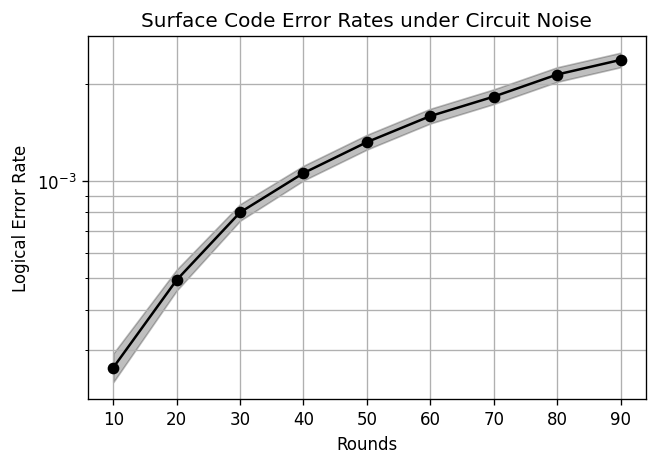

In [1703]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['r'],
    # group_func=lambda stat: stat.json_metadata['d'],
    # failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)
# ax.set_ylim(5e-3, 5e-2)
# ax.set_xlim(0.008, 0.012)
ax.semilogy()
ax.set_title("Surface Code Error Rates under Circuit Noise")
ax.set_xlabel("Rounds")
ax.set_ylabel("Logical Error Rate")
ax.grid(which='major')
ax.grid(which='minor')
# ax.legend()
fig.set_dpi(120)  # Show it bigger

In [554]:
circuit = stim.Circuit(
"""
QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 0) 3
QUBIT_COORDS(4, 0) 4
QUBIT_COORDS(0, 1) 5
QUBIT_COORDS(1, 1) 6
QUBIT_COORDS(2, 1) 7
QUBIT_COORDS(3, 1) 8
QUBIT_COORDS(4, 1) 9
QUBIT_COORDS(0, 2) 10
QUBIT_COORDS(1, 2) 11
QUBIT_COORDS(2, 2) 12
QUBIT_COORDS(3, 2) 13
QUBIT_COORDS(4, 2) 14
QUBIT_COORDS(0, 3) 15
QUBIT_COORDS(1, 3) 16
QUBIT_COORDS(2, 3) 17
QUBIT_COORDS(3, 3) 18
QUBIT_COORDS(4, 3) 19
QUBIT_COORDS(0, 4) 20
QUBIT_COORDS(1, 4) 21
QUBIT_COORDS(2, 4) 22
QUBIT_COORDS(3, 4) 23
QUBIT_COORDS(4, 4) 24
R 0 2 4 6 8 10 12 14 16 18 20 22 24 1 3 5 7 9 11 13 15 17 19 21 23
TICK
H 1 3 11 13 21 23
TICK
CX 1 2 11 12 21 22 3 4 13 14 23 24 6 5 16 15 8 7 18 17
TICK
CX 1 6 11 16 3 8 13 18 10 5 20 15 12 7 22 17 14 9 24 19
TICK
CX 11 6 21 16 13 8 23 18 0 5 10 15 2 7 12 17 4 9 14 19
TICK
CX 1 0 11 10 21 20 3 2 13 12 23 22 6 7 16 17 8 9 18 19
TICK
H 1 3 11 13 21 23
TICK
MR 1 3 11 13 21 23 5 7 9 15 17 19
DETECTOR(4, 3, 0) rec[-1]
DETECTOR(2, 3, 0) rec[-2]
DETECTOR(0, 3, 0) rec[-3]
DETECTOR(4, 1, 0) rec[-4]
DETECTOR(2, 1, 0) rec[-5]
DETECTOR(0, 1, 0) rec[-6]
X_ERROR(1) 2
REPEAT 1 {
    TICK
    H 1 3 11 13 21 23
    TICK
    CX 1 2 11 12 21 22 3 4 13 14 23 24 6 5 16 15 8 7 18 17
    TICK
    CX 1 6 11 16 3 8 13 18 10 5 20 15 12 7 22 17 14 9 24 19
    TICK
    CX 11 6 21 16 13 8 23 18 0 5 10 15 2 7 12 17 4 9 14 19
    TICK
    CX 1 0 11 10 21 20 3 2 13 12 23 22 6 7 16 17 8 9 18 19
    TICK
    H 1 3 11 13 21 23
    TICK
    MR 1 3 11 13 21 23 5 7 9 15 17 19
    SHIFT_COORDS(0, 0, 1)
    DETECTOR(4, 3, 0) rec[-1] rec[-13]
    DETECTOR(2, 3, 0) rec[-2] rec[-14]
    DETECTOR(0, 3, 0) rec[-3] rec[-15]
    DETECTOR(4, 1, 0) rec[-4] rec[-16]
    DETECTOR(2, 1, 0) rec[-5] rec[-17]
    DETECTOR(0, 1, 0) rec[-6] rec[-18]
    DETECTOR(3, 4, 0) rec[-7] rec[-19]
    DETECTOR(1, 4, 0) rec[-8] rec[-20]
    DETECTOR(3, 2, 0) rec[-9] rec[-21]
    DETECTOR(1, 2, 0) rec[-10] rec[-22]
    DETECTOR(3, 0, 0) rec[-11] rec[-23]
    DETECTOR(1, 0, 0) rec[-12] rec[-24]
}
M 0 2 4 6 8 10 12 14 16 18 20 22 24
DETECTOR(4, 3, 1) rec[-1] rec[-4] rec[-6] rec[-14]
DETECTOR(2, 3, 1) rec[-2] rec[-4] rec[-5] rec[-7] rec[-15]
DETECTOR(0, 3, 1) rec[-3] rec[-5] rec[-8] rec[-16]
DETECTOR(4, 1, 1) rec[-6] rec[-9] rec[-11] rec[-17]
DETECTOR(2, 1, 1) rec[-7] rec[-9] rec[-10] rec[-12] rec[-18]
DETECTOR(0, 1, 1) rec[-8] rec[-10] rec[-13] rec[-19]
OBSERVABLE_INCLUDE(0) rec[-11] rec[-12] rec[-13]
"""
)



In [596]:
sampler = circuit.without_noise().compile_sampler()
one_sample = sampler.sample(shots=1)[0]
print(len(one_sample))

for k in range(0, len(one_sample), 12):
    timeslice = one_sample[k:k+12]
    print("".join("1" if e else "_" for e in timeslice))

37
__1_________
__1_________
_111111_1___
_


In [604]:
sampler = circuit.compile_detector_sampler()
one_sample = sampler.sample(shots=1, append_observables=True)[0][6:]
print(len(one_sample))

for k in range(0, len(one_sample), 12):
    timeslice = one_sample[k:k+12][::-1]
    print("".join("1" if e else "_" for e in timeslice))

19
_______1____
1______
